# Brute Force Utility Functions

In this notebook we write some functions that will be useful for opening & analysing the output from our stochastic integrations of the L96 EBM model.

In [34]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde

In [2]:
# Data Directories

# k5_eps0_1_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k5_eps0_1/'
# k5_eps0_01_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k5_eps0_01/'
# k20_eps0_01_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k20_eps0_01/'

k40_eps0_1_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k40_eps0_1_SHORT'


### Function for Opening the Data

In [3]:
def load_run(d, s=slice(0, 10, 1)):
    """
    Loads array jobs run in to a list.
    
    d, param, string: name of directory containing array jobs run.
    s, param, slice: way of indexing.
    results, output, list: list of xarray datasets.   
    """
    results = [] 
    runs = os.listdir(d) # list of array job runs
    runs.sort(key=float)
    for file in tqdm(runs[s]):
        folder = d + '/' + file +'/'
        for Tfile in os.listdir(folder):
            subfolder = folder + Tfile
            ds = xr.open_mfdataset(subfolder+ '/*.nc', parallel=True, combine='by_coords', concat_dim='time')
            results.append(ds)
    return results

In [4]:
def close(run):
    for ds in run:
        ds.close()
    print('Closed Run')

In [7]:
# Example Use

test_dir = '/rds/general/user/cfn18/ephemeral/L96-EBM-Stochastic/k40_eps0_1_SHORT'

results = load_run(test_dir, slice(0, 20))

### Checks on Data Integrity

- Check the timepoints were all accounted for

[8008, 15015, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100, 100100]


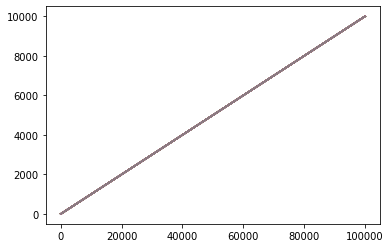

In [20]:
fig, ax = plt.subplots()
lengths = []

for ds in results:
    plt.plot(ds.time)
    lengths.append(len(ds.time))
print(lengths)

### Functions for finding Transitions

In [16]:
def rare_event_search(runs, thres=(270, 280)):
    """
    Searchs a list of xarrays for rare event trajectories and stores them in a list.
    
    runs, param, list: list of data sets we're checking.
    thres, param, tuple: (cold, hot) threshold.
    rare_events, output, list: list of xarray datasets that have transitions.   
    """
    rare_events = []
    print('Checking for transition trajectories')
    for ds in tqdm(runs):
        cold = ds.T.values<thres[0]
        hot = ds.T.values>thres[1]
        transition = np.any(cold) & np.any(hot)
        if transition:
            print('Found one!')
            rare_events.append(ds)
    return rare_events

In [11]:
# Example Use

res = rare_event_search(results, thres=(270, 270))

Found one!



In [19]:
def re_dir_search(d, thres=(270, 280)):
    """
    Searchs a whole array jobs run for rare events.
    
    d, param, string: name of directory containing array jobs run.
    thres, param, tuple: (cold, hot) threshold.
    rare_events, output, list: list of xarray datasets that have transitions.   
    """

    rare_events = []
    
    # Split Run in to Blocks of 10
    length = int(len(os.listdir(k40_eps0_1_dir)))
    Print(f'There are {length} blocks to search')
    remainder = length%10
    no_of_blocks = int((length - remainder)/10)

    slices = [slice(i * 10, (i + 1) * 10) for i in range(no_of_blocks)]
    remainder_slice = slice(length - remainder, length)
    slices.append(remainder_slice)
    
    # For each block, open ds and check if there is a rare event
    for s in tqdm(slices):
        print('Loading a block')
        results = load_run(d, s)
        rare_events +=  rare_event_search(results, thres=thres)
        close(results)
        
    print(f'I found {len(rare_events)} transitions')

    return rare_events


In [15]:
# Example Use
re_dir_search(test_dir)


Closed Run



Closed Run



Closed Run



Closed Run



Closed Run



[]

### Functions for Evaluation the Data

In [23]:
def timeseries_plot(t, x, x_name='', save=None):
    "Plots x timeseries"
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel(x_name)
    title = 'Timeseries of' + ' ' + x_name
    ax.set_title(title)
    ax.plot(t, x)
    
    if (save is None):
        fig.show()
        return fig, ax # Return in case you want to edit plot options
    else:
        fig.savefig(save)
    return

In [39]:
def summary_stats(d, densities=False):
    "Takes dataset, prints/plots summary stats."
    # Remove Transient
    transient=1000
    ds = d.isel(time=slice(transient,-1))
    
    # T Stats
    T_mean = ds.T.mean().values
    T_var = ds.T.var().values
    print(f'T mean is {T_mean:.2f}\n')
    print(f'T variance is {T_var:.2f}')
    
    if densities:
        density_plot(ds.T.values, 'Temperature PDF', 'T')

    # X Stats Displayed as a plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    for ax in axes:
        ax.grid()
        ax.set_xlabel('Spatial Coordinate')
    axes[0].scatter(ds.X.space, ds.X.mean(dim='time'))
    axes[0].set_ylabel('Time Mean')
    axes[0].set_title('X Means')
    axes[1].scatter(ds.X.space, ds.X.var(dim='time'))
    axes[1].set_ylabel('Time Variance')
    axes[1].set_title('X Variances')
    fig.show()
    
    if densities:
        density_plot(ds.X.values.flatten(), 'X PDF - All Spatial Points', 'X') 

In [42]:
def density_plot(samples, title, xlabel='', save=None):
    "Given data samples uses KDE to plot PDF."
    fig, ax = plt.subplots(figsize=(7, 7))
    x_d = np.linspace(samples.min(), samples.max(), int(len(samples)/100)) # Grid we evaluate PDF on
    kde = gaussian_kde(samples) # KDE. Using Gaussian ker
    pdf = kde.evaluate(x_d)
    ax.plot(x_d, pdf)
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel(xlabel)
#     ax.plot(samples, np.full_like(samples, -0.01), 'k*', label='samples')
#     ax.legend()
    ax.grid()
    ax.set_title(title)
    if (save!=None):
        print(f'Saving plot at {save}')
        fig.savefig(save, dpi=1200)
    fig.show()

T mean is 257.38

T variance is 5.80


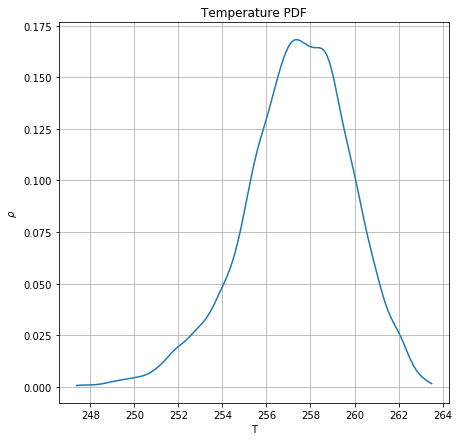

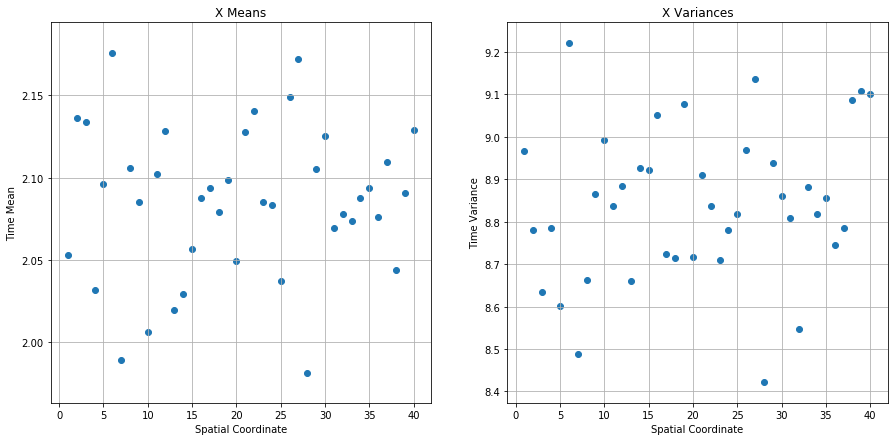

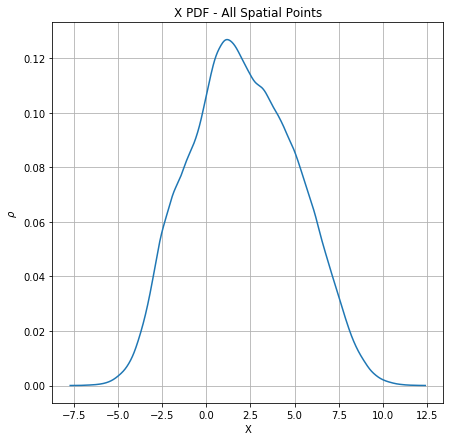

In [43]:
summary_stats(results[1], densities=True)

In [61]:
def energy_time_plot(d, thres=(275, 280)):
    """
    3D plot of energy, time and temperature. 
    Colors attractors according to temperatures in thres.
    
    ds, param, xr.dataset: the data we're plotting.
    thres, param, tuple: (cold, hot). 
        x< cold is blue.
        cold<x<hot is green.
        x> hot is red.
    """
        
    # Remove Transient & thin out
    transient=1000
    ds = d.isel(time=slice(transient,-1))
                
    energy_ts = 0.5 * (ds.X**2).mean(dim='space').values
    
    cold = ds.T.values < thres[0]
    hot = ds.T.values > thres[1]
    transition = (ds.T.values>thres[0]) * (ds.T.values<thres[1])

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(ds.time.values[cold], energy_ts[cold], ds.T.values[cold], 'b')
    ax.plot(ds.time.values[transition], energy_ts[transition], ds.T.values[transition], 'g')
    ax.plot(ds.time.values[hot], energy_ts[hot], ds.T.values[hot], 'r')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('$\\mathcal{E}$')
    ax.set_zlabel('$T$')
    fig.show()
    
    return fig, ax

In [60]:
def energy_mean_plot(d, thres=(275, 280)):
    """
    Attractor Projection Plot.
    3D plot of energy, mean and temperature. 
    Colors attractors according to temperatures in thres.
    
    d, param, xr.dataset: the data we're plotting.
    thres, param, tuple: (cold, hot). 
        x< cold is blue.
        cold<x<hot is green.
        x> hot is red.
    """
    # Remove Transient & thin out
    transient=1000
    ds = d.isel(time=slice(transient,-1))

    energy_ts = 0.5 * (ds.X**2).mean(dim='space').values
    mean_ts = ds.X.mean(dim='space').values

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    cold = ds.T.values < thres[0]
    hot = ds.T.values > thres[1]
    transition = (ds.T.values>thres[0]) * (ds.T.values<thres[1])
    
    ax.plot(mean_ts[cold], energy_ts[cold], ds.T.values[cold], 'b')
    ax.plot(mean_ts[transition], energy_ts[transition], ds.T.values[transition], 'g')
    ax.plot(mean_ts[hot], energy_ts[hot], ds.T.values[hot], 'r')

    ax.set_xlabel('$\\mathcal{M}$')
    ax.set_ylabel('$\\mathcal{E}$')
    ax.set_zlabel('$T$')
    fig.show()
    
    return fig, ax

In [45]:
from mpl_toolkits.mplot3d import Axes3D


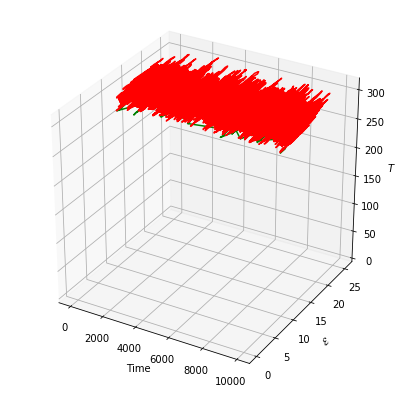

In [65]:
energy_time_plot(results[2])

In [249]:
dire = '/rds/general/user/cfn18/home/Instantons/L96-EBM-Instanton/Brute-Force/TEST/SRI2/T_256_963935'
dire2 = '/rds/general/user/cfn18/home/Instantons//L96-EBM-Instanton/Brute-Force/TEST/SRI2/T_294_440564'
ds = xr.open_mfdataset(dire + '/*.nc', parallel=True, combine='by_coords', concat_dim='time')
ds2 = xr.open_mfdataset(dire2 + '/*.nc', parallel=True, combine='by_coords', concat_dim='time')

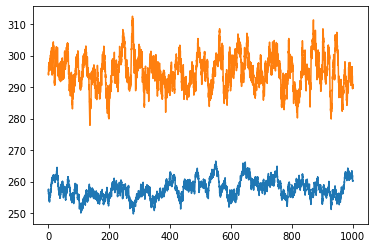

In [251]:
plt.plot(ds.time, ds.T)
plt.plot(ds2.time, ds2.T)

In [254]:
len(ds.time)

10010